# Bachelor project: High Frequency Hygrometer

This is where I keep all the charts and code for those charts that I used in my report.  
You can find the full code in the github repository.  
This jupyter file will cover the following:
1. A simulation of the intensity loss.
2. A real-life error check.
3. A plot of the error over different path lengths.
4. The simulation of the theorised total setup/system.
5. A real-life test, to see if there is truth to the theory.
6. A plot of the measured voltage just before the measurements.

### importing libraries, data and functions

I start with importing numpy, which is needed for my functions. <br>
I will use pyplot throughout this file, I need Line2D for my legend in the second plot.<br>

Then I am importing stuff for a 3D plot.

And I import the data and functions. (need to install ipynb)

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 

# I need to get some fancy 3d tools, thats why this is imported
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# ! pip install ipynb
from ipynb.fs.full.Data import *
from ipynb.fs.full.Functions import *

I want to readout my test data first by doing this:
<br>
I add all the data into 1 dictionary, to be easily accessible.

In [2]:
tests = [test_1, test_2, test_3]
data = []

for test in tests:
    resistor, distance_lamp_to_box, distance_box_to_detector, start_test, humidity, dark_voltage, light_voltage, temperature, \
    voltage_gain = test_data_reader(test)

    data.append({"resistor": resistor, "distance_lamp_to_box": distance_lamp_to_box,
                 "distance_box_to_detector": distance_box_to_detector, "start_test":start_test, "humidity": humidity,
                 "dark_voltage": dark_voltage,
                 "light_voltage": light_voltage, "temperature": temperature, "voltage_gain": voltage_gain})


## Simulation charts

Here I will start with the plots and data I got for the simulations.<br>

**This is all based upon the WIKIPEDIA_DATA_TESTS in github.**

choosing the wavelength, this could be any out of the WIKI_workable_available_wavelengths (can be found in data, or you could print(WIKI_get_workable_absorption_coeff_water()) ).

This loads all the possible wavelength:attenuation factors. (which was used in different simulations, but we decided to use 940nm for all the tests)

In [3]:
# choosing our wavelength
wavelength = 940e-9

absorption_coefficient_water = WIKI_get_workable_absorption_coeff_water()[wavelength]

#### Intensity loss 

I will start with a simulation of the attenuation of 940nm wavelength light.
line 19: I start of with calculating the intensity loss. This happens by first dividing the humidity by 100, so that we get a decimal percentage. After that it calculates the maximum amount of water that is in the air, using the function calculate_maximum_percentage_water(T) depending on the temperature. With that we calculate the $ attenuation\_factor = mu_{H2O} * humidity * max\_percentage\_water $. Then we use the beer lambert law: $I_{loss} = I_0 * exp(attenuation\_factor * path\_length)$.


in github the code can be found as TEST_7.

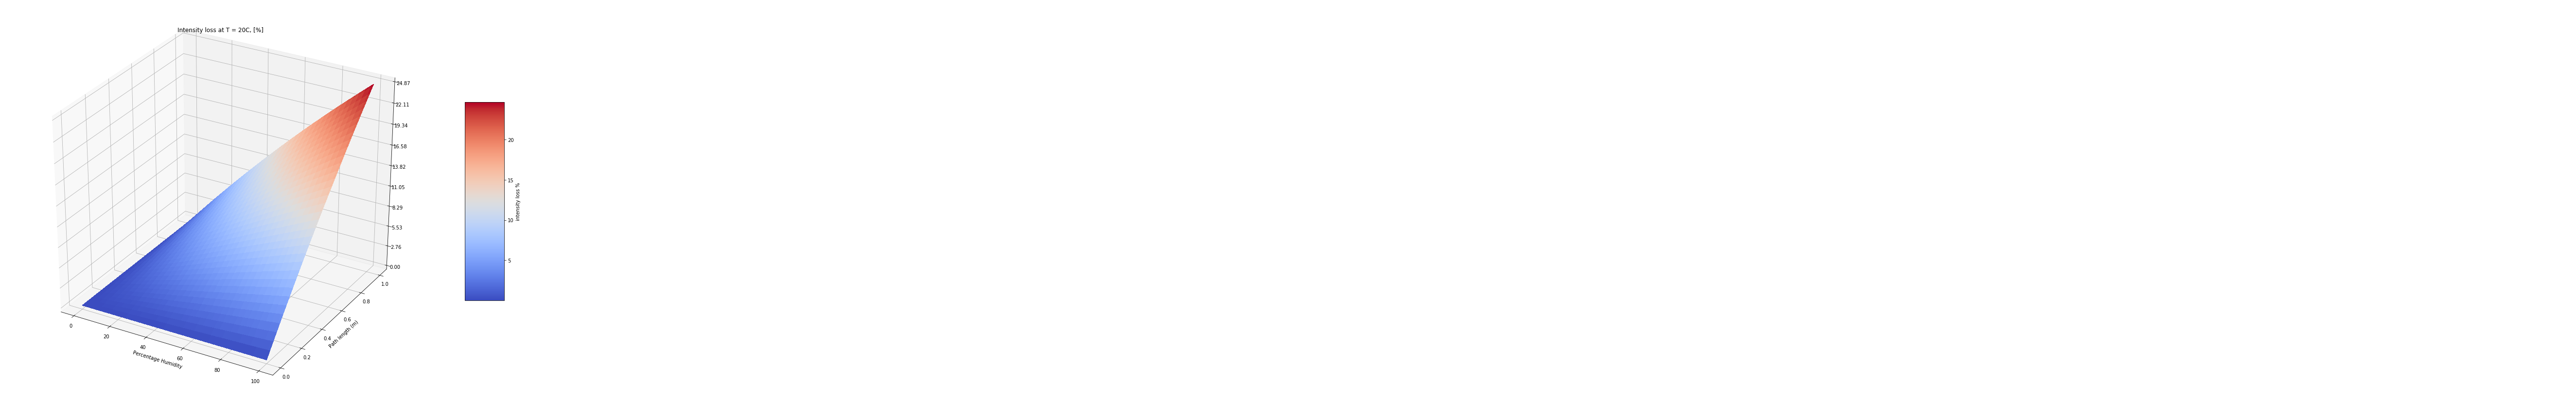

In [4]:
# I chose something around room temperature for the temperature
T = 20  # Celsius
# choosing a starting intensity, which in does not matter in fact, I will calculate a percentage loss at the end
start_intensity = 0.100  # Watt/cm2

# lists needed for the plot
# I need a 2D array for the the 3D plot, this is the axis of humidity
array_humidity = make_2d_humidity_array(101, 101)  # %
# same, but now for the path length axis
array_path_length = make_2d_path_length_array(101, 101)  # meter

# Making an empty array, to fill with our simulation calculations
array_intensity_loss = np.zeros((101, 101))

# starting the loop over the humidity-pathlength axes to fill up the intensity_loss array
for i in range(len(array_humidity[0, :])):
    for j in range(len(array_path_length[0, :])):
        
        # see text above: line 19
        intensity_loss = WIKI_find_intensity_loss(start_intensity, array_path_length[j, 0],
                                                      absorption_coefficient_water, array_humidity[0, i], T)
        
        # here we make the loss the percentage that is left of the original intensity and add it into our array.
        array_intensity_loss[i,j] = (intensity_loss/start_intensity)*100

# here we convert the percentage left to a percentage loss.
array_intensity_loss = 100 - array_intensity_loss

# plotting
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(array_humidity, array_path_length, array_intensity_loss, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5, label='intensity loss %')

plt.title(f'Intensity loss at T = {T}C, [%]')
plt.ylabel('Path length (m)')
plt.xlabel('Percentage Humidity')

plt.savefig("intensity_loss")
plt.show()

#### Error check

The following simulation will use the Law of Large Numbers (LLN) to estimate the average error we get when I can only read the intensity at a certain accuracy, namely the amount of decimals, or significance. This is because it is impossible to measure at 7 or more decimals with equipment that is affordable.

Line 31: here i calculate the maximum amount of water that the air can hold at temperature T, so it returns the $max\_concentration * \mu_{H_2 O}$

line 47: then I calculate backwards with $c_{H_2O} = \frac{\ln{I_{0}} - \ln{I}}{\alpha_{H_2O} x}$ where $c_{H_2O}$ is the concentration and thus the humidity that we calculate.

This is based of of TEST_8 in github.
but here we use N = 100000 to speed it up.

In [5]:
# I wanted to see the error at all temperatures, but if you want you can turn this off.
random_temperature = True  # if you want to look at a certain temperature set this to False
# defining a starting intensity
start_intensity = 0.100  # Watt/cm2
# setting the path length
path_length = 0.2  # meter

# setting the variable to change the significance
# decimals rounded, defaults to .1 mW
decimal_round = 4

# number of iterations for the LLN
N = 100000

# if u wanted a set temperature, you can do that here
if not random_temperature:
    T = 10

# empty list to to fill all the error percentages in, to later get the average
error_list = []

# starting the error calculations for N times.
for i in range(N):
    # making a random humidity, so in theory that is for example the humidity outside
    REAL_humidity = np.random.randint(0, 100)  # %
    
    # making a random T if thats what u want
    if random_temperature:
        T = np.random.randint(-20, 60)
    
    # see line 31 above
    max_attenuation_factor_water = WIKI_absorption_coefficient_air_composition_max_humidity_at_T(absorption_coefficient_water, T)
    
    # Then with the max attenuation factor I calculate the maximum intensity loss. 
    # So I know that the intensity that I will measure will be between 0 and this max value, in fact;
    max_intensity_loss = measure_intensity(start_intensity, max_attenuation_factor_water, path_length)
    
    # The amount of intensity I should measure is the percentage of humidity, 
    # the same percentage of the maximum concentration of water, which I do in this line of code.
    random_intensity = ((max_intensity_loss - start_intensity) * REAL_humidity / 100) + start_intensity
    
    # because you then get a number with many decimals, 
    # I round that to display an accurate measurement done in real life (say measuring 4 decimals of intensity)
    # to make this work as a real life situation, we cannot measure at 10 decimals
    random_intensity = round(random_intensity, decimal_round)
    
    # see line 47 above
    humidity = WIKI_find_humidity_from_intensity_at_T(start_intensity, random_intensity, path_length,
                                                 absorption_coefficient_water, T)
    
    # Then I just calculate the absolute difference between the real percentage
    # in line 25 and the backwardly calculated one in line 48. This I add to the list
    error_list.append(abs(humidity-REAL_humidity))

# I can just calculate the average now and I print it.
print(f"\nThe average error for {decimal_round} decimals W/cm2 with random temperature for wavelength {wavelength*1e9} nm is: \n"
      f"{sum(error_list)/len(error_list)} %")


The average error for 4 decimals W/cm2 with random temperature for wavelength 940.0 nm is: 
2.146704483768555 %


#### Error plots

This plot will show the error like the script above does, but now over different path lengths, from 1 cm to 99 cm. The 3rd for loop I wont cover at length, because its the same as the script above.

This is based upon TEST 9 in github.   
If you want to run this, use N = 20.000, because 100.000 takes a long time.

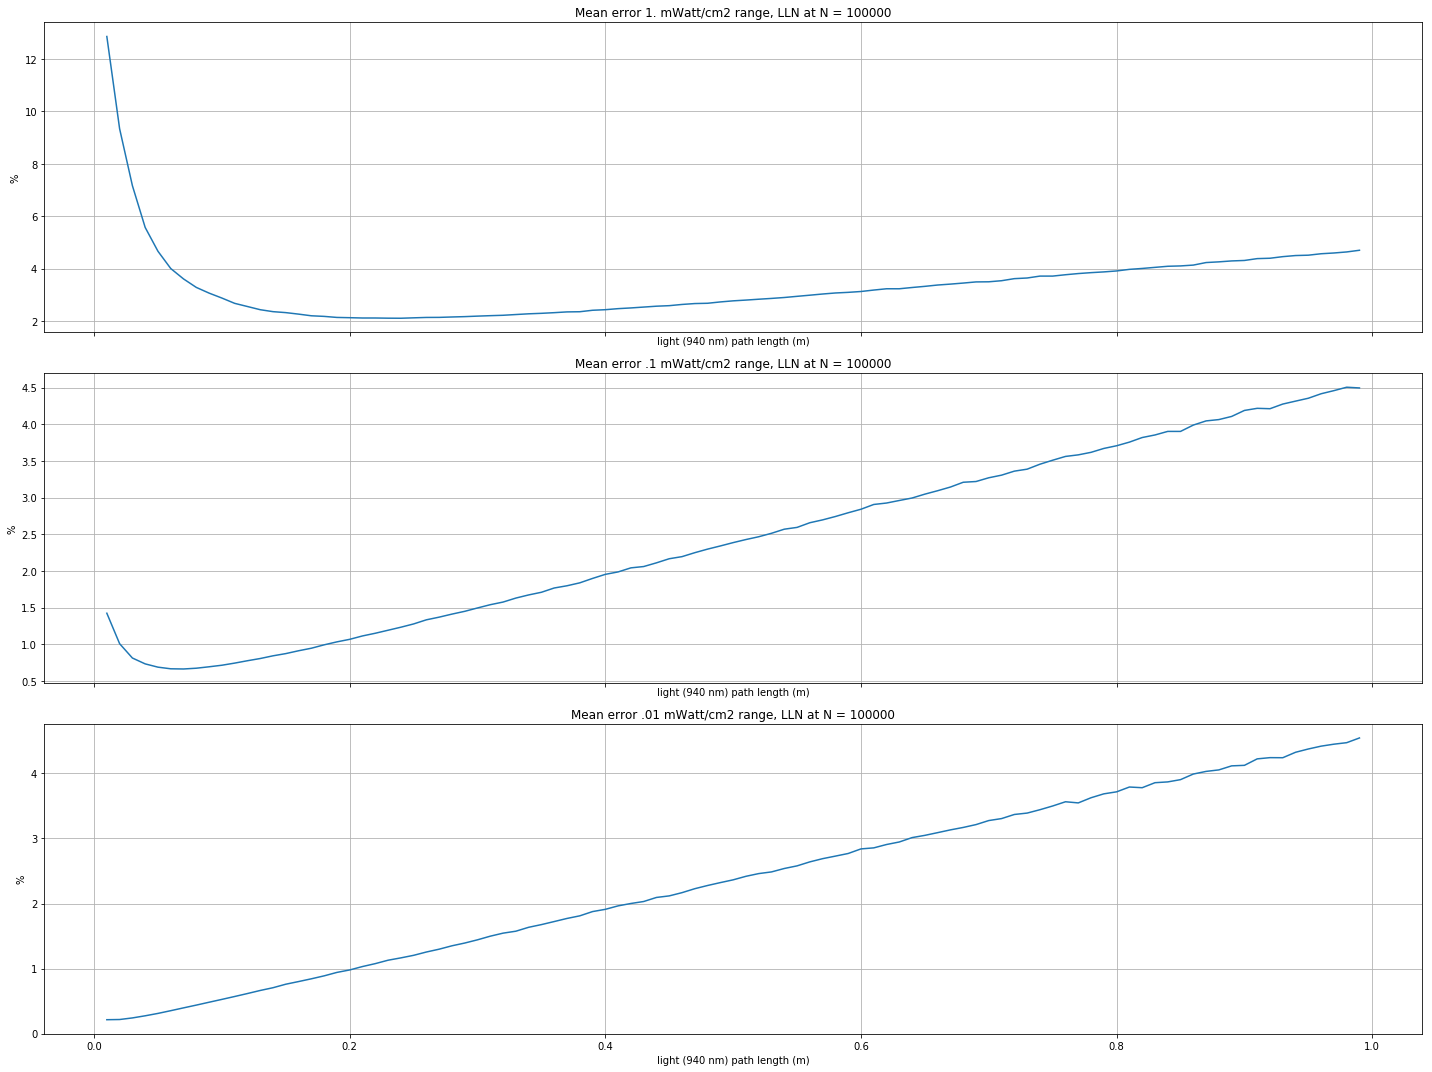

In [6]:
# get a starting intensity
start_intensity = 1  # mWatt/cm2
# getting the path length array for the plots
path_length_array = make_2d_path_length_array(101, 101)  # meter
# because the array is square, which I dont need I make it (101,3)
path_length_array = path_length_array[:,:3]
# ditching the 0 cm's in the array, because it's trivial so it is (100,3)
path_length_array = path_length_array[1:,:] # dont want the the path length of 0

# etting the array of decimals to round which is (100,3)
decimal_round_array = make_2d_decimal_array(100)

# number of iterations
N = 20000

# if we want to control the temperature, we do that here
random_temperature = True
if not random_temperature:
    T = 10

# making the empty array to fill for the plots
error_array = np.zeros((100,3))

# looping ofer the path length steps
for i in range(len(path_length_array[:,0])):
    # looping over the 3 possible decimal points
    
    for j in range(len(decimal_round_array[0,:])):
        
        # the list to add the error percentages in
        temp_error_list = []
        
        # the same loop as above
        for _ in range(N):
            REAL_humidity = np.random.randint(0, 100)  # %
            if random_temperature:
                T = np.random.randint(-20, 60)

            max_attenuation_factor_water = WIKI_absorption_coefficient_air_composition_max_humidity_at_T(absorption_coefficient_water, T)

            max_intensity_loss = measure_intensity(start_intensity, max_attenuation_factor_water, path_length_array[i, 0])

            random_intensity = ((max_intensity_loss - start_intensity) * REAL_humidity / 100) + start_intensity

            #measuring at different decimals (3,4,5)
            random_intensity = round(random_intensity, int(decimal_round_array[0,j]))

            humidity = WIKI_find_humidity_from_intensity_at_T(start_intensity, random_intensity, path_length_array[i,0],
                                                         absorption_coefficient_water, T)

            temp_error_list.append(abs(humidity-REAL_humidity))
            
        # I add the average error in our error array
        error_array[i,j] = sum(temp_error_list)/len(temp_error_list)

# there are some NaN values that I remove
error_array = error_array[1:,:]  # first row are nan

# making the plots
fig, axs = plt.subplots(3, 1, sharex='col', figsize=(20, 15))
axs[0].plot(path_length_array[:-1,0], error_array[:,0])
axs[0].set_title(f"Mean error 1. mWatt/cm2 range, LLN at N = {N}")

axs[1].plot(path_length_array[:-1,0], error_array[:,1])
axs[1].set_title(f"Mean error .1 mWatt/cm2 range, LLN at N = {N}")

axs[2].plot(path_length_array[:-1,0], error_array[:,2])
axs[2].set_title(f"Mean error .01 mWatt/cm2 range, LLN at N = {N}")

for i in range(3):
    axs[i].grid()
    axs[i].set_xlabel(f'light ({wavelength*1e9:.0f} nm) path length (m)')
    axs[i].set_ylabel('%')

plt.tight_layout()
plt.savefig("error_plots")
plt.show()

#### System simulation

This is the final plot, this simulates the system as I theorised it, it also has some error calculations in it, to get a feel of the parameters. I also noted that the diameter of the laser takes a huge error with it, this is ofcourse because the intensity at the detector will be altered drastically.

You can find the original code under TEST_16.

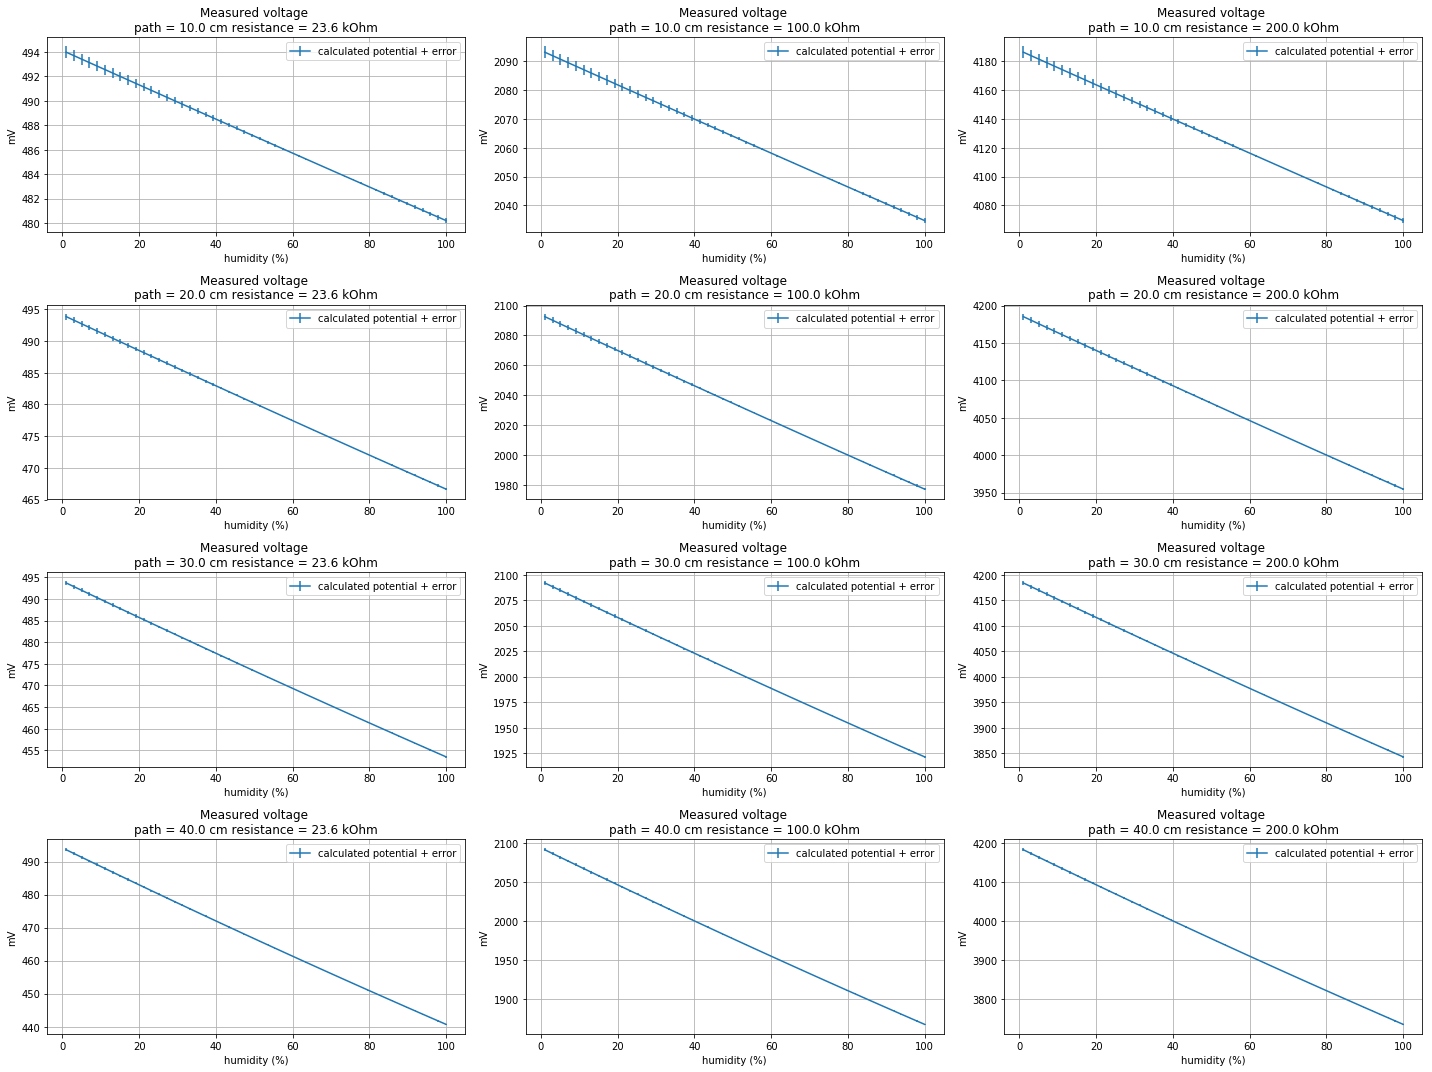

In [21]:
"""this py file tests the whole system and its variables"""

# |---- system variables ----|

# setting the laser power
laser_power = 1  # mWatt
# the diameter of the laser bundle
diameter_laser = 15  # mm
# an array of the path lengths from 10 to 99 centimeters
laser_path_length = np.arange(0.1, .5, .1)  # m
# the different resistors that I theorised
resistance_resistor = [23.6e3, 1e5, 2e5]  # Ohm
# because the sensor has spectral sensitivity, I added this, this should be in my data file, but I was lazy
relative_spectral_sensitivity = 1  # 940nm

# specifying the reverse voltage of the circuit, 
# this is done because the voltage we will measure over the resistance can never be more than the reverse voltage
reverse_voltage = 5
# error in the resistance
resistor_error = 0.001
# error in the path length
path_length_error = 0.005  # m = .5 cm

# error in the diameter of the laser, I set this to 0 because it hugely alters the intensity at the sensor, 
# when this is done IRL you should know the intensity at the sensor quite well, so it should not matter.
diameter_laser_error = 0  # mm

# |---- data ----|
# this test is done at a set temperature
temperature = 20  # C
# an array for the humidity from 1 to 100, which will be our x-axis in the plots
humidity = np.linspace(1, 100)  # %

# |---- empty array for plots ----|

# making the array to fill in with the data for all the plots, this will be copied for both error arrays
y = np.zeros((len(laser_path_length), len(humidity), len(resistance_resistor)))
error_low = y.copy()
error_high = y.copy()
error_difference = y.copy()
# empty list to add the intensities that will arrive at the sensor
intensity = []


# |---- calculations ----|
# up to line 62 will calculate the intensity that will arrive at the sensor. The errors are done seperately
surface_area_laser = np.pi * (diameter_laser / 2) ** 2  # mm2

surface_area_laser_low = np.pi * ((diameter_laser - diameter_laser_error) / 2) ** 2  # mm2
surface_area_laser_high = np.pi * ((diameter_laser + diameter_laser_error) / 2) ** 2  # mm2

surface_area_detector = 6.5  # mm2
intensity_at_laser_tip = laser_power / surface_area_laser  # mWatt/mm2

intensity_at_laser_tip_low = laser_power / surface_area_laser_low  # mWatt/mm2
intensity_at_laser_tip_high = laser_power / surface_area_laser_high  # mWatt/mm2

intensity_at_laser_tip *= 100  # mWatt/cm2
intensity_at_laser_tip_low *= 100  # mWatt/cm2
intensity_at_laser_tip_high *= 100  # mWatt/cm2

intensity.append(intensity_at_laser_tip)

# starting a loop over the possible humidities, 
# this loop will calculate the theoretical value of intensity that will arrive at the sensor, 
# afterwhich it calculates what the voltage would be over the resistor
for hum in range(len(humidity)):
    
    # |---- humidity calculations ----|
    
    # loop over all the laser path lengths
    for i in range(len(laser_path_length)):
        
        # calculate the maximum attenuation of the water at temperature T, so at 100% humidity
        max_attenuation = WIKI_absorption_coefficient_air_composition_max_humidity_at_T(
            absorption_coefficient_water, temperature)  # c_max * a
        
        # calculate the intensity at the current humidity level
        attenuation = (humidity[hum] / 100) * max_attenuation # c * a
        
        # calculate the intensity at the sensor that arrives after being attenuated
        light_at_detector = measure_intensity(intensity_at_laser_tip, attenuation, laser_path_length[i])
        
        # the error calculations
        light_at_detector_low_error = measure_intensity(intensity_at_laser_tip_low, attenuation, laser_path_length[i] - path_length_error)
        light_at_detector_high_error = measure_intensity(intensity_at_laser_tip_high, attenuation, laser_path_length[i] + path_length_error)

        # |---- calculating the current this induces ----|
        
        # converting the intensity of the light on the sensor to a induced current, which is done via the data sheet of the sensor 
        # link of datasheet: https://rocelec.widen.net/view/pdf/k7jo7wfaxu/ONSM-S-A0003544331-1.pdf?t.download=true&u=5oefqw 
        induced_current = photodetector_1(light_at_detector) * relative_spectral_sensitivity
        
        # # the error calculations
        induced_current_low_error = photodetector_1(light_at_detector_low_error) * relative_spectral_sensitivity
        induced_current_high_error = photodetector_1(light_at_detector_high_error) * relative_spectral_sensitivity

        # the data for our plots for later
        y[i, hum, :] = induced_current
        error_low[i, hum, :] = induced_current_low_error
        error_high[i, hum, :] = induced_current_high_error

# more calculations
# I name it resistor_measurement already (even though it is still the current)
resistor_measurement = y.copy()

# here I go from current to a voltage
for i in range(len(resistance_resistor)):
    resistor_measurement[:, :, i] *= resistance_resistor[i]

# here I name it the voltage as well
voltage_measured = resistor_measurement  # this is sloppy, i know

# check if the voltage exceeds reverse voltage
for i in range(len(voltage_measured[:, 0, 0])):
    for j in range(len(voltage_measured[0, :, 0])):
        for k in range(len(voltage_measured[0, 0, :])):

            if voltage_measured[i, j, k] > reverse_voltage:
                voltage_measured[i, j, k] = reverse_voltage

# I add the resistor error into the mix, afterwhich I am checking for the reverse voltage again.
for i in range(len(resistance_resistor)):
    low_point = (resistance_resistor[i] - (resistance_resistor[i] * resistor_error))
    high_point = (resistance_resistor[i] + (resistance_resistor[i] * resistor_error))
    error_low[:, :, i] *= low_point
    error_high[:, :, i] *= high_point
    error_difference[:, :, i] = abs(error_high[:, :, i] - error_low[:, :, i])

# check if the voltage exceeds reverse voltage
for i in range(len(voltage_measured[:, 0, 0])):
    for j in range(len(voltage_measured[0, :, 0])):
        for k in range(len(voltage_measured[0, 0, :])):

            if error_low[i, j, k] > reverse_voltage:
                error_low[i, j, k] = reverse_voltage
            if error_high[i, j, k] > reverse_voltage:
                error_high[i, j, k] = reverse_voltage

# I loop over all the data in the errors to get the difference in errors, which I will use in the plot
for i in range(len(resistance_resistor)):
    error_difference[:, :, i] = abs(error_high[:, :, i] - error_low[:, :, i])

# to make the data into mV
voltage_measured *= 1e3  
error_low *= 1e3
error_high *= 1e3
# here I make it into milli volt and I devide by 2, because the error bar that I plot isn't entirely correct, 
# it just adds the error on top and on the bottom, thats why I devide it by 2.
error_difference *= 1e3 / 2

# plot
fig, axs = plt.subplots(len(laser_path_length), len(resistance_resistor), figsize=(20, 15))

for i in range(len(laser_path_length)):
    for j in range(len(resistance_resistor)):
        axs[i, j].errorbar(humidity, voltage_measured[i, :, j], yerr=error_difference[i, :, j],
                           fmt='-', label='calculated potential + error')
        axs[i, j].set_title(
            f"Measured voltage \n"
            f"path = {laser_path_length[i] * 100:.1f} cm resistance = {resistance_resistor[j]/1000:.1f} kOhm")
        axs[i, j].grid()
        axs[i, j].set_xlabel(f'humidity (%)')
        axs[i, j].set_ylabel('mV')
        axs[i, j].legend()


plt.tight_layout()
plt.savefig("final_simulation")
plt.show()

## Testing charts

Lets start with our first plot that will show all the data at once.

The 3 tests differ by 2 things.
1. the resistor changes.
2. the distance from the lamp to the lid of the box.

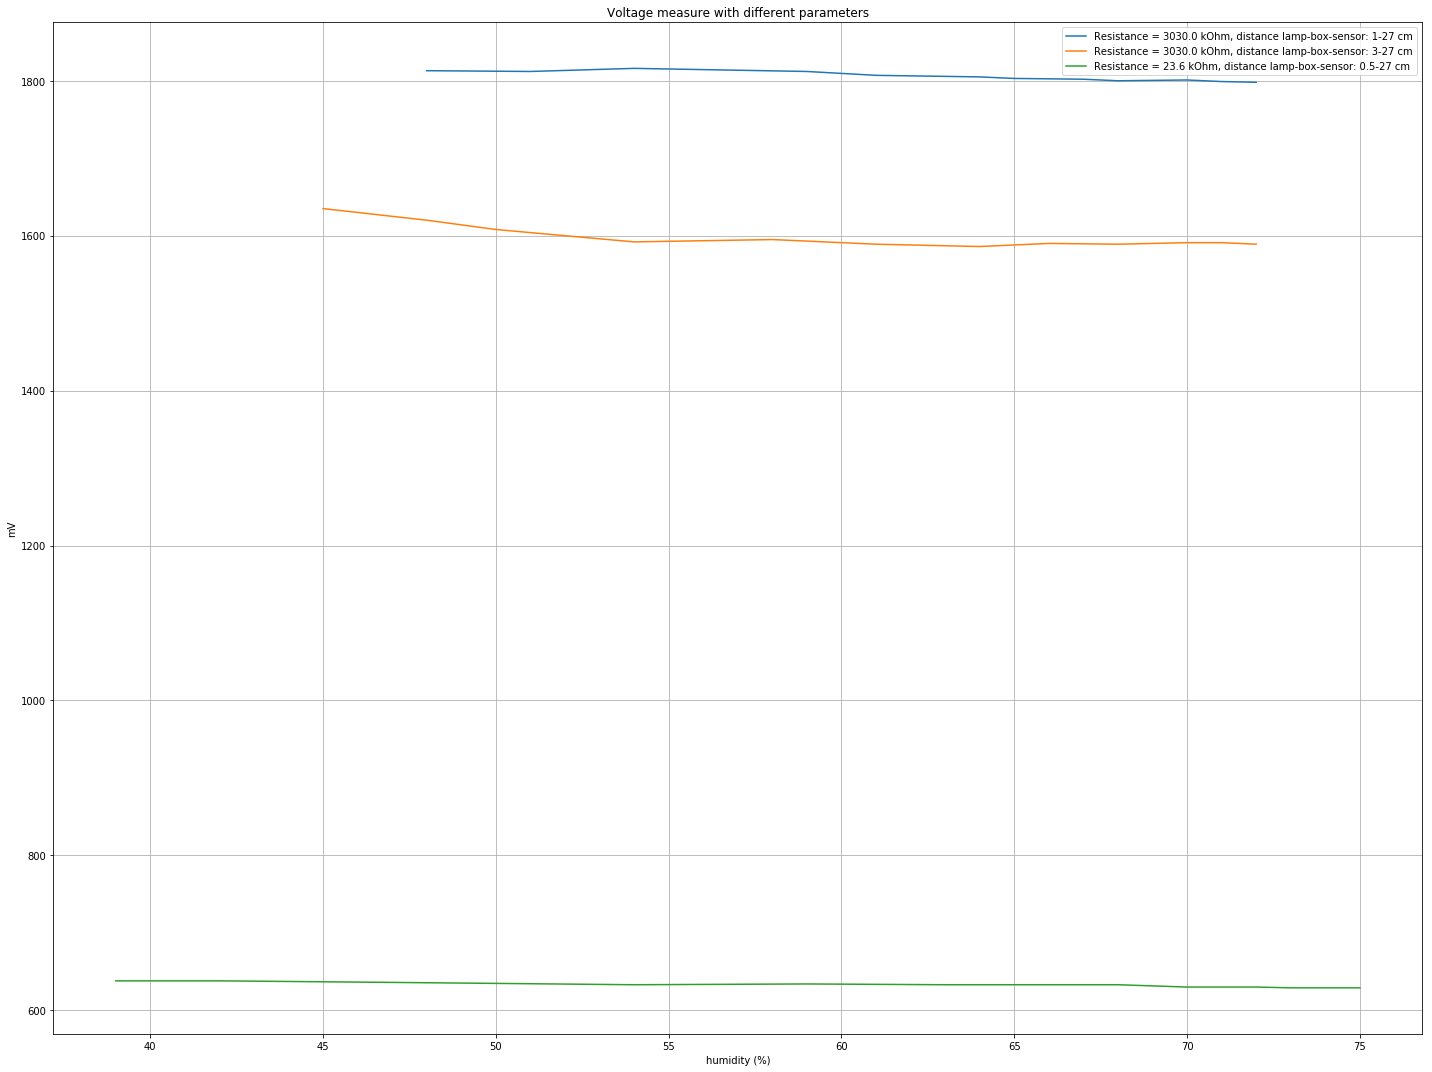

In [8]:
plt.rcParams["figure.figsize"] = (20, 15)

for i in range(len(data)):
    x = data[i]["humidity"]
    y = data[i]["voltage_gain"]
    plt.plot(x, y, label=f'Resistance = {data[i]["resistor"] / 1000} kOhm, distance lamp-box-sensor: '
                     f'{data[i]["distance_lamp_to_box"]}-{data[i]["distance_box_to_detector"]} cm')

plt.title(f'Voltage measure with different parameters')
plt.grid()
plt.xlabel(f'humidity (%)')
plt.ylabel('mV')
plt.legend()
plt.tight_layout()
# plt.savefig("data_better")
plt.show()

#### Measured voltage

Now we will look at the 3 different seperatly, because as you can see the plot above is unreadable.

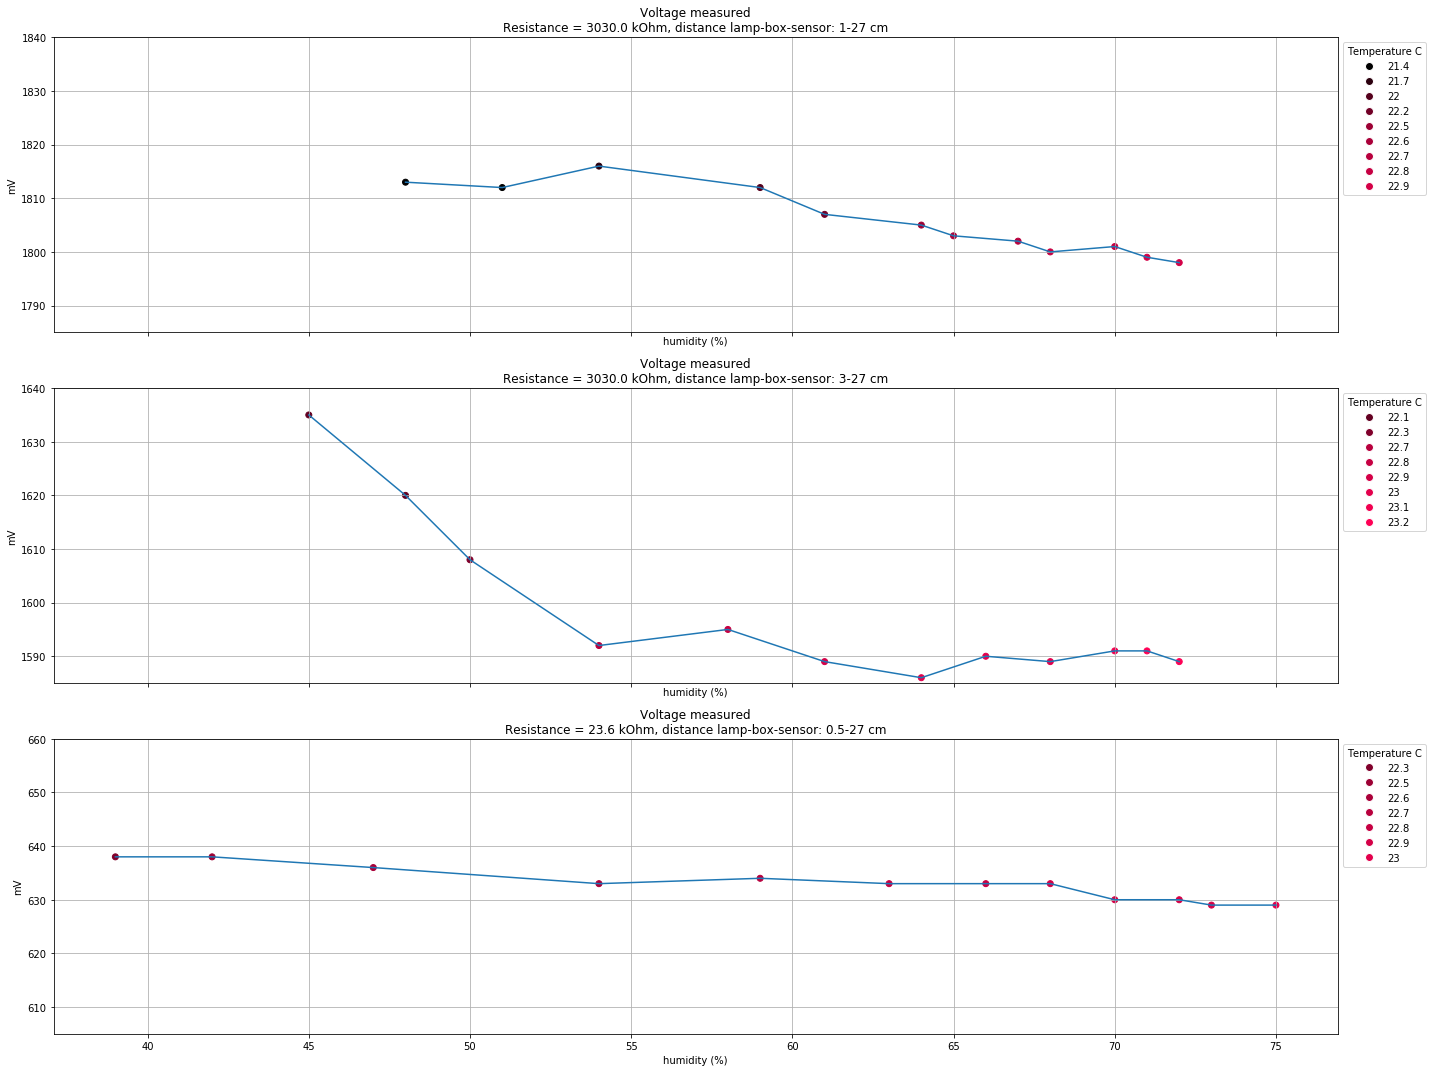

In [22]:
# first of all I create a figure with the same amount of subplots as datasets I have, using "sharex" to allign the humidity axis.
fig, axs = plt.subplots(len(data), figsize=(20, 15), sharex=True)

# filling the plots, per data set
for i in range(len(data)):
    
    # creating the x-axis, which takes the humidity list from the dataset
    x = data[i]["humidity"]
    # y-axis, takes the data list from the dataset, 
    # which is the voltage read from the voltmeter with the lamp on, minus the voltage read with the lamp off.
    y = data[i]["voltage_gain"]
    
    # I also want to show temperature
    temp = data[i]["temperature"]
    
    # this line takes the function that leaves a dict of color and a list of the colors. The dict looks as follows: [RGB]:color. 
    # I had to make my own color scheme for this plot, the same goes for the legend, thats why this is here.
    color_dict, color = color_magic(temp)
    
    # plots the data per test in the correct subplot
    axs[i].plot(x, y)
    axs[i].scatter(x, y, c=color)
    
    # these are the handles for the legend of the color in the plots
    handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in
               color_dict.items()]
    # actually putting in the legend
    axs[i].legend(title='Temperature C', handles=handles, bbox_to_anchor=(1, 1), loc='upper left')
    
    # he title for the plots, the lamp-box-sensor means; the lamp was above the boxlid, 
    # so the distance from the lamp to the box lid is the first number, 
    # and then the distance from the lid to the sensor is the 27 cm.
    axs[i].set_title(f'Voltage measured\n'
                     f'Resistance = {data[i]["resistor"] / 1000} kOhm, '
                     f'distance lamp-box-sensor: {data[i]["distance_lamp_to_box"]}-{data[i]["distance_box_to_detector"]} cm')
    axs[i].grid()
    axs[i].set_xlabel(f'humidity (%)')
    axs[i].set_ylabel('mV')

# putting in a y range for 55 millivolt
axs[0].set_ylim([1785, 1840])
axs[1].set_ylim([1585, 1640])
axs[2].set_ylim([605, 660])

plt.tight_layout()
plt.savefig("Results")
plt.show()

#### Dark Voltage

Now lets take a look at the voltage that I measured with the lamp turned off, before the measurement. We will call it the dark voltage from now on, to make it a bit easier.

I am basically using the same code as before, but now I change line 5, with dark_voltage, adding the starting time of the experiment and removing the range.

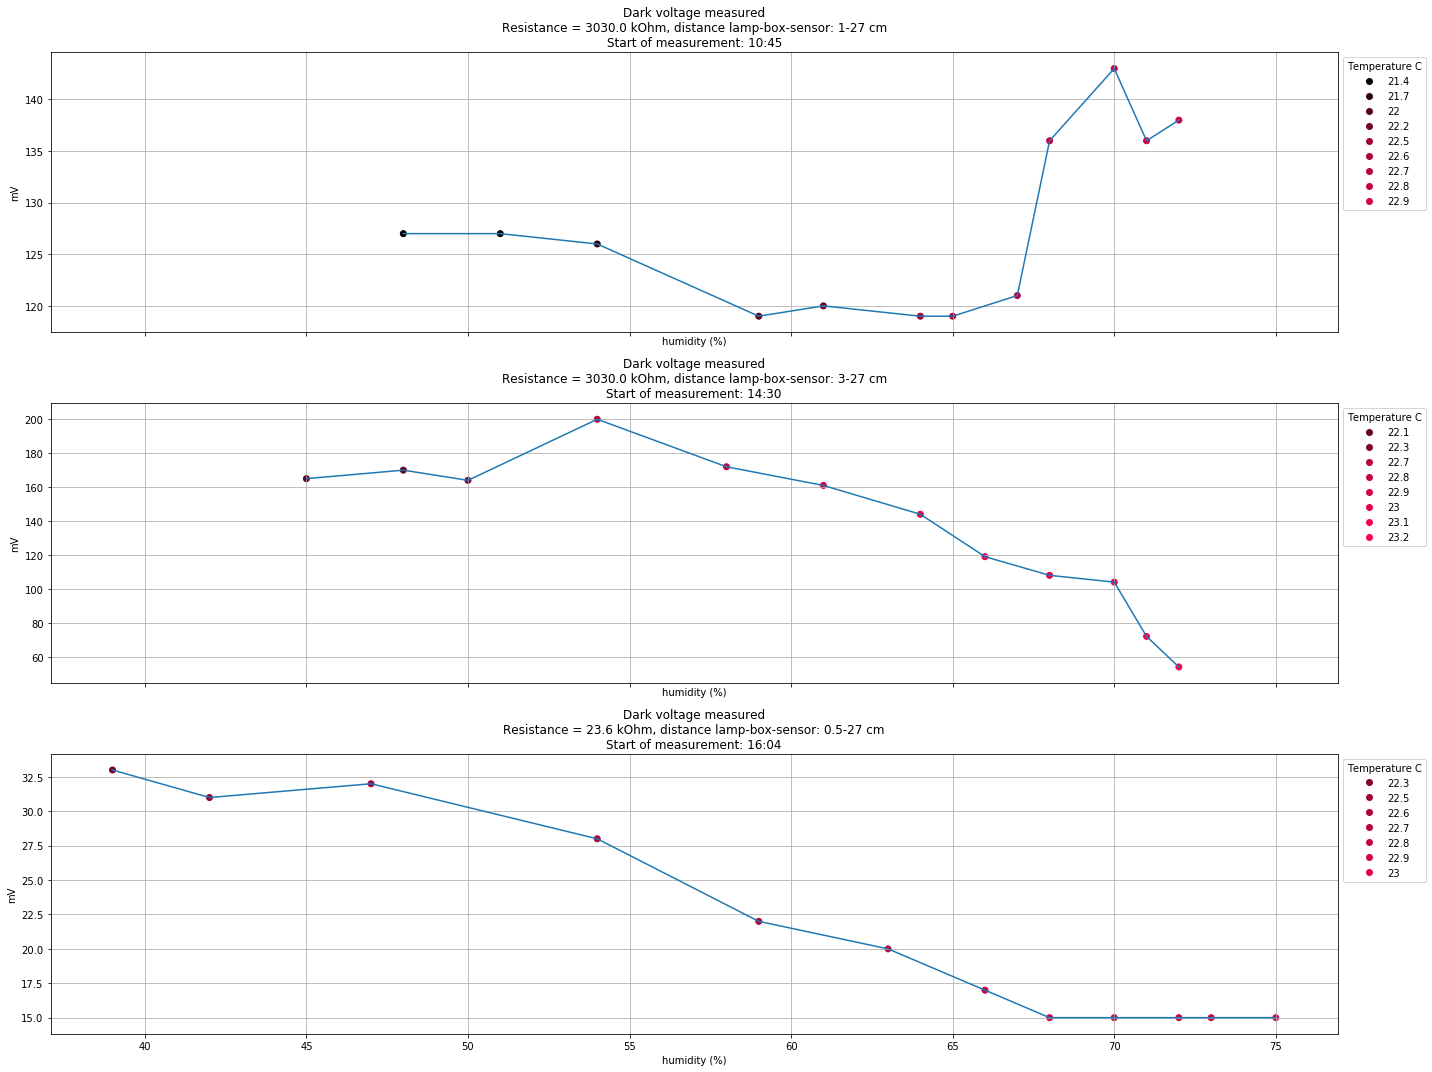

In [24]:
fig, axs = plt.subplots(len(data), figsize=(20, 15), sharex=True)

for i in range(len(data)):
    x = data[i]["humidity"]
    y = data[i]["dark_voltage"]
    temp = data[i]["temperature"]
    color_dict, color = color_magic(temp)
    axs[i].plot(x, y)
    axs[i].scatter(x, y, c=color)
    handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in
               color_dict.items()]
    axs[i].legend(title='Temperature C', handles=handles, bbox_to_anchor=(1, 1), loc='upper left')

    axs[i].set_title(f'Dark voltage measured\n'
                     f'Resistance = {data[i]["resistor"] / 1000} kOhm, '
                     f'distance lamp-box-sensor: {data[i]["distance_lamp_to_box"]}-{data[i]["distance_box_to_detector"]} cm\n'
                     f'Start of measurement: {data[i]["start_test"]}')
    axs[i].grid()
    axs[i].set_xlabel(f'humidity (%)')
    axs[i].set_ylabel('mV')

plt.tight_layout()
plt.savefig("dark_voltage")
plt.show()